In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys, os, time, collections

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR']bb, 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
Cannot import mxnet.
Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/

In [11]:
def fun_similar_ratio(data, threshold_simu):
    return np.float(np.count_nonzero(data>threshold_simu))/len(data)

In [12]:
def fun_max_similarity(positive_data, negative_data, plotFig=False):
    tempPosCum = []
    tempNegCum = []
    tempRanges = np.arange(0,1.05,0.05)
    for threshold_simu in tempRanges:
        tempPosCum.append(fun_similar_ratio(positive_data, threshold_simu=threshold_simu))
        tempNegCum.append(fun_similar_ratio(negative_data, threshold_simu=threshold_simu))

    tempDifference = np.array(tempPosCum) - np.array(tempNegCum)
    tempMax = np.max(tempDifference)
    tempPos = tempRanges[tempDifference==tempMax]
    if plotFig:
        plt.figure()
        plt.plot(tempRanges, tempPosCum, label='Positive')
        plt.plot(tempRanges, tempNegCum, label='Negative')
        plt.plot(tempRanges, tempDifference, label='Difference')
        plt.xlabel('Threshold Similarity')
        plt.title('Max difference = %f @ s=%f'%(tempMax,tempPos))
        plt.grid()
        plt.legend()
    return tempPos, tempMax

### Load data

In [2]:
stack = 'MD589'
dataFolderName = 'NoCoords'
scan_parameters = load_typical_cell_data(what='scan_parameters', stack=stack, sec=200, dataFolderName=dataFolderName, dataType='typical')

In [3]:
section_valid_list = fun_get_valid_section_list(stack)
section_load_list = list(section_valid_list)

# Load saved blob features of {typical_blob, matched_pair, false_typical, false_matched_pairs}
typical_blob_props = collections.defaultdict(dict)
matched_blob_props = collections.defaultdict(dict)
false_typical_blob_props = collections.defaultdict(dict)
false_matched_blob_props = collections.defaultdict(dict)
for tempProp in scan_parameters['prop_to_save']:
    for tempSec in section_valid_list:
        try:
            typical_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='typical')
            matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='matched')
            false_typical_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='false_typical')
            false_matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='false_matched')
        except:
            section_load_list.remove(tempSec)
            print('Cannot load the data of section %d'%tempSec)
            
for tempSec in section_valid_list:
    typical_blob_props[tempSec]['numBlobs'] = len(typical_blob_props[tempSec]['area'])
    false_typical_blob_props[tempSec]['numBlobs'] = len(false_typical_blob_props[tempSec]['area'])
# Load matching infomation            
for tempProp in ['section', 'TBID']:
    for tempSec in section_valid_list:
        try:
            matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='matched')
            false_matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='false_matched')
        except:
            section_load_list.remove(tempSec)
            print('Cannot load the data of section %d'%tempSec)
# Get relation between TBID and matched blob idx
TBID_to_matched_blob = collections.defaultdict(dict)
for tempSec in section_load_list:
    for tempBID in range(typical_blob_props[tempSec]['numBlobs']):
        TBID_to_matched_blob[tempSec][tempBID] = np.where(matched_blob_props[tempSec]['TBID']==tempBID)[0]

# Get map between False typical blob ID and false_matched blobs idx
FTBID_to_false_matched_blob = collections.defaultdict(dict)
for tempSec in section_load_list:
    for tempBID in range(false_typical_blob_props[tempSec]['numBlobs']):
        FTBID_to_false_matched_blob[tempSec][tempBID] = np.where(false_matched_blob_props[tempSec]['TBID']==tempBID)[0]

In [4]:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
vertice_dic = collections.defaultdict(dict)
structure_section_list = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    vertice_dic[structure_name] = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()} 
    structure_section_list[structure_name] = np.sort(vertice_dic[structure_name].keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  07292017045157


In [5]:
structure_name = '7N'
TBID_in_structure = collections.defaultdict(dict)
FTBID_in_structure = collections.defaultdict(dict)
for tempSec in set(section_load_list).intersection(structure_section_list[structure_name]):
    TBID_in_structure[tempSec][structure_name] =  np.where(fun_blobs_in_polygen(typical_blob_props[tempSec]['centroid'], vertice_dic[structure_name][tempSec]))[0]
    FTBID_in_structure[tempSec][structure_name] = np.where(fun_blobs_in_polygen(false_typical_blob_props[tempSec]['centroid'], vertice_dic[structure_name][tempSec]))[0]

# Training set of 7N

In [149]:
scan_parameters['prop_to_save']

['moments_hu',
 'centroid',
 'area',
 'eccentricity',
 'equivalent_diameter',
 'compactness']

In [6]:
scan_parameters['training_props'] = training_props = ['area', 'eccentricity', 'compactness','moments_hu']

### Positive

In [7]:
positive_similarity_sec_prop = collections.defaultdict(dict)
for tempSec in TBID_in_structure.keys():
    for tempProp in training_props:
        temp_sec_prop_similarity = []
        for tempBID in TBID_in_structure[tempSec][structure_name]:
            temp = fun_similarity(typical_blob_props[tempSec][tempProp][tempBID], 
                                                  matched_blob_props[tempSec][tempProp][TBID_to_matched_blob[tempSec][tempBID]],distance_type=tempProp)
            temp_sec_prop_similarity += temp
        positive_similarity_sec_prop[tempSec][tempProp] = temp_sec_prop_similarity
        
positive_similarity_prop = {}
for tempProp in training_props:
    positive_similarity_prop[tempProp] = np.concatenate(tuple([np.array(record[tempProp]) for record in positive_similarity_sec_prop.itervalues()]))

temp_training_data = []
for tempProp in training_props:
    temp_training_data.append(positive_similarity_prop[tempProp])
positive_training_data = np.column_stack(tuple(temp_training_data))

### Negative

In [8]:
negative_similarity_sec_prop = collections.defaultdict(dict)
for tempSec in FTBID_in_structure.keys():
    for tempProp in training_props:
        temp_sec_prop_similarity = []
        for tempBID in FTBID_in_structure[tempSec][structure_name]:
            temp = fun_similarity(false_typical_blob_props[tempSec][tempProp][tempBID], 
                                                  false_matched_blob_props[tempSec][tempProp][FTBID_to_false_matched_blob[tempSec][tempBID]],distance_type=tempProp)
            temp_sec_prop_similarity += temp
        negative_similarity_sec_prop[tempSec][tempProp] = temp_sec_prop_similarity
        
negative_similarity_prop = {}
for tempProp in training_props:
    negative_similarity_prop[tempProp] = np.concatenate(tuple([np.array(record[tempProp]) for record in negative_similarity_sec_prop.itervalues()]))

temp_training_data = []
for tempProp in training_props:
    temp_training_data.append(negative_similarity_prop[tempProp])
negative_training_data = np.column_stack(tuple(temp_training_data))

Tune weight, try to seperate two distribution

In [281]:
maxSimDiff_scan = []
threshold_s_scan = []
tempWeightScan_range = range(0,200)
for tempWeight1 in tempWeightScan_range:
    weight = np.array([[100,70,tempWeight1]], dtype=np.float).T
    weight = weight / np.sum(weight)
    positive_weighted_similarity = np.dot(positive_training_data, weight)
    negative_weighted_similarity = np.dot(negative_training_data, weight)
    threshold_s, maxSimDiff = fun_max_similarity(positive_weighted_similarity, negative_weighted_similarity, plotFig=False)
    maxSimDiff_scan.append(maxSimDiff)
    threshold_s_scan.append(threshold_s)

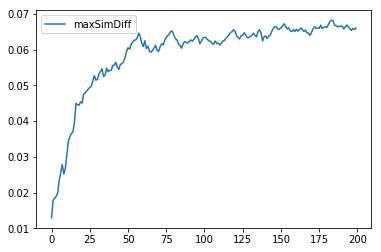

In [282]:
plt.plot(tempWeightScan_range, maxSimDiff_scan,label='maxSimDiff')
# plt.plot(tempWeightScan_range, threshold_s_scan,label='threshold_sim')
plt.legend()

In [ ]:
data_weight = []
data_maxSimDiff = []

In [ ]:
data_weight = list(data_weight)
data_maxSimDiff = list(data_weight)
numTry = 400
numTryPerTime = 5000
for tempTry in range(0, numTry):
    print(float(tempTry)/numTry)
    for temp in range(0,numTryPerTime):
        weight = np.random.random(size=[10,1])
        weight = weight / np.sum(weight)
        positive_weighted_similarity = np.dot(positive_training_data, weight)
        negative_weighted_similarity = np.dot(negative_training_data, weight)
        threshold_s, maxSimDiff = fun_max_similarity(positive_weighted_similarity, negative_weighted_similarity, plotFig=False)
        data_weight.append(weight.flatten())
        data_maxSimDiff.append(maxSimDiff)        

0.0
0.0025
0.005
0.0075
0.01
0.0125
0.015
0.0175
0.02
0.0225
0.025
0.0275
0.03
0.0325
0.035
0.0375
0.04
0.0425
0.045
0.0475
0.05
0.0525
0.055
0.0575
0.06
0.0625
0.065
0.0675
0.07
0.0725
0.075
0.0775
0.08
0.0825
0.085
0.0875
0.09
0.0925
0.095
0.0975
0.1
0.1025
0.105
0.1075
0.11
0.1125
0.115
0.1175
0.12
0.1225
0.125
0.1275
0.13
0.1325
0.135
0.1375
0.14
0.1425
0.145
0.1475
0.15
0.1525
0.155
0.1575
0.16
0.1625
0.165
0.1675
0.17
0.1725
0.175
0.1775
0.18
0.1825
0.185
0.1875
0.19
0.1925
0.195
0.1975
0.2
0.2025
0.205
0.2075
0.21


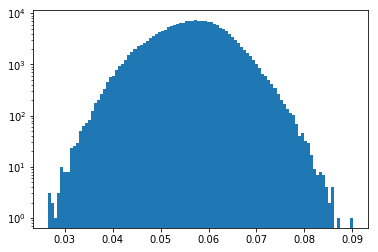

In [46]:
tempNumBin = 100
plt.hist(data_maxSimDiff, tempNumBin);
plt.yscale('log')

In [53]:
data_weight = np.array(data_weight)
data_maxSimDiff = np.array(data_maxSimDiff)

In [55]:
tempGoodResult = data_weight[data_maxSimDiff > 0.09]
tempGoodResult

array([[ 0.03790475,  0.21910964,  0.22538714,  0.30655242,  0.11137249,
         0.05859679,  0.01298738,  0.00860598,  0.00076326,  0.01872014]])

In [36]:
np.mean(tempGoodResult,axis=0)

array([ 0.1409527 ,  0.09251426,  0.17445499,  0.2445358 ,  0.15494736,
        0.10157409,  0.01670953,  0.01659806,  0.03115833,  0.02655489])

In [37]:
np.std(tempGoodResult, axis=0)

array([ 0.08352517,  0.06060316,  0.07200623,  0.05314914,  0.03721815,
        0.05702869,  0.01609641,  0.01189383,  0.03799994,  0.03407772])

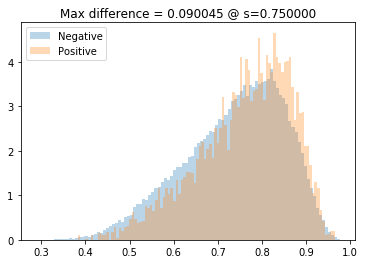

In [56]:
tempBinNum = 100
tempNormed = True
tempCumulated = False

# weight = np.array([[20,15,50]], dtype=np.float).T
# weight = weight / np.sum(weight)
weight = tempGoodResult[0,:]
positive_weighted_similarity = np.dot(positive_training_data, weight)
negative_weighted_similarity = np.dot(negative_training_data, weight)
threshold_s, maxSimDiff = fun_max_similarity(positive_weighted_similarity, negative_weighted_similarity, plotFig=False)
plt.figure()
plt.hist(negative_weighted_similarity,bins=tempBinNum,normed=tempNormed, alpha=0.3,cumulative=tempCumulated, label='Negative');
plt.hist(positive_weighted_similarity,bins=tempBinNum,normed=tempNormed,alpha=0.3,cumulative=tempCumulated, label='Positive');
plt.title('Max difference = %f @ s=%f'%(maxSimDiff, threshold_s))
plt.legend()

# Analysis

### Distribution differnece

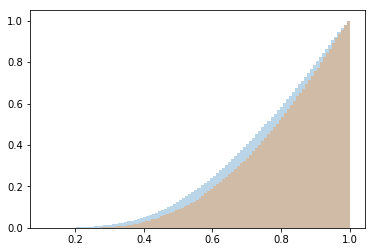

In [214]:
tempProp = 'compactness'
tempBinNum = 100
plt.hist(negative_similarity_prop[tempProp],bins=tempBinNum,normed=True, alpha=0.3,cumulative=True);
plt.hist(positive_similarity_prop[tempProp],bins=tempBinNum,normed=True,alpha=0.3,cumulative=True);

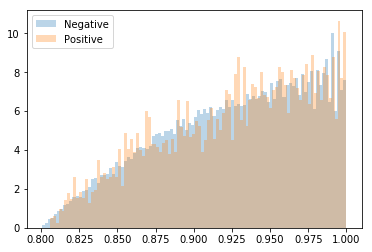

In [231]:
tempProp = 'area'
tempBinNum = 100
tempNormed = True
tempCumulated = False
plt.hist(negative_similarity_prop[tempProp],bins=tempBinNum,normed=tempNormed, alpha=0.3,cumulative=tempCumulated, label='Negative');
plt.hist(positive_similarity_prop[tempProp],bins=tempBinNum,normed=tempNormed,alpha=0.3,cumulative=tempCumulated, label='Positive');
plt.legend()

# Whole Brainstem matching results

In [9]:
tempSec = 152
TBID_in_structure[tempSec][structure_name]

array([7351, 7354, 7364, 7374, 7380])

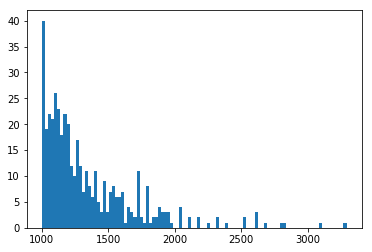

In [24]:
# 
temp = false_matched_blob_props[152]['area']
plt.hist(temp[temp>1000], bins=100);

In [31]:
matched_blob_props[tempSec]['TBID']

array([   0,    0,    0, ..., 7435, 7436, 7437], dtype=int16)

In [7]:
# margin = 10
# bboxs_7N = {sec:fun_polygon_bbox(vertice_7N_dic[sec]) for sec in sectionList_7N}
# bbox_7N = fun_polygons_bbox(bboxs_7N.values(),margin=margin)
# # bbox_7N = bboxs_7N[154]
# scan_parameters['crop_range_mmxx'] = bbox_7N
# scan_parameters['crop_0_min'], scan_parameters['crop_1_min'],scan_parameters['crop_0_max'],scan_parameters['crop_1_max'] = bbox_7N 
# scan_parameters['im0max'] = scan_parameters['crop_0_max'] - scan_parameters['crop_0_min']
# scan_parameters['im1max'] = scan_parameters['crop_1_max'] - scan_parameters['crop_1_min']
# scan_parameters['crop_range_mxmx'] = fun_mmxx_to_mxmx(*scan_parameters['crop_range_mmxx'])

In [8]:
# Get avaliable sections:
stack = scan_parameters['stack']
section_begin, section_end = scan_parameters['section_limits']
load_section_num = 100
load_start_section = 152 - section_begin
all_valid_section = fun_get_valid_section_list(stack=stack)
# secList = all_valid_section[load_start_section:load_section_num + load_start_section]
# secList = list(set(all_valid_section).intersection(sectionList_7N))
secList = all_valid_section
scan_parameters['secList'] = secList

In [139]:
# # loading data
# image = {}
# for tempSec in secList:
#     try:
#         image[tempSec] = fun_crop_images(DataManager.load_image_v2(stack=stack, section=tempSec, version='jpeg', prep_id=2),*scan_parameters['crop_range_mmxx'],im0max=scan_parameters['oriImL0'],im1max=scan_parameters['oriImL1'] )
#     except:
#         sys.stderr.write('Cannot import section %d...\n'%tempSec)
#         continue